**Importing Libraries**

In [1]:
import os 
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D, MaxPooling2D, BatchNormalization,Dropout, Flatten,Activation,concatenate,Input,AlphaDropout
from keras.optimizers import Adam
from keras.utils import to_categorical
import tensorflow as tf
import random as rn
import cv2                  
from tqdm import tqdm
from random import shuffle  
import itertools
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras import backend as K

Using TensorFlow backend.


**Creating Dataset**

In [2]:
x=[]
y=[]
size=150
path='../input/flowers/'
for ftype in os.listdir(path):
    for img in tqdm(os.listdir(path+ftype)):
        label=ftype
        path1 = os.path.join(path+ftype,img)
        img = plt.imread(path1)
        img = cv2.resize(img, (size,size))
        x.append(np.array(img))
        y.append(str(label))

100%|██████████| 784/784 [00:05<00:00, 133.22it/s]


In [3]:
encoder=LabelEncoder()
y=encoder.fit_transform(y)
y=to_categorical(y,5)
x=np.array(x)

**Splitting Data into Training, Testing and Validation Datasets**

In [4]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.10,random_state=42,stratify=y_train)

In [5]:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

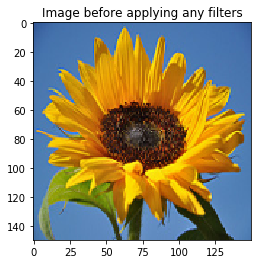

In [6]:
plt.imshow(x_train[1277])
plt.title("Image before applying any filters")
plt.show()

**Applying Gabor Filter**

In [7]:
gaborx_train=[]
gaborx_val=[]
gaborx_test=[]

g_kernel = cv2.getGaborKernel((13, 13), 4.0, 56.2, 10.0, 1, 0, ktype=cv2.CV_32F)

    
for image in x_train:
    gabor_feature = cv2.filter2D(image, cv2.CV_8UC3, g_kernel)
    gaborx_train.append(gabor_feature)

for image in x_val:
    gabor_feature = cv2.filter2D(image, cv2.CV_8UC3, g_kernel)
    gaborx_val.append(gabor_feature)

for image in x_test:
    gabor_feature = cv2.filter2D(image, cv2.CV_8UC3, g_kernel)
    gaborx_test.append(gabor_feature)

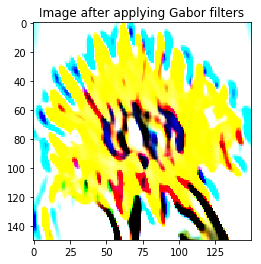

In [8]:
plt.imshow(gaborx_train[1277])
plt.title("Image after applying Gabor filters")
plt.show()

**Applying Sharp Filter**

In [9]:
sharpx_train=[]
sharpx_val=[]
sharpx_test=[]

skernel = np.array([[-1,-1,-1], [-1,10,-1], [-1,-1,-1]])

for image in x_train:
    sharp = cv2.filter2D(image, -1, skernel)
    sharpx_train.append(sharp)

for image in x_val:
    sharp = cv2.filter2D(image, -1, skernel)
    sharpx_val.append(sharp)

for image in x_test:
    sharp = cv2.filter2D(image, -1, skernel)
    sharpx_test.append(sharp)

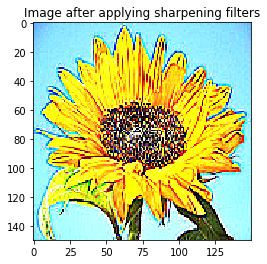

In [10]:
plt.imshow(sharpx_train[1277])
plt.title("Image after applying sharpening filters")
plt.show()

**Applying Guassian Filter**

In [11]:
gaussx_train=[]
gaussx_val=[]
gaussx_test=[]


for image in x_train:
    gauss_feature = cv2.GaussianBlur(image, (3, 33), 0)
    gaussx_train.append(gauss_feature)

for image in x_val:
    gauss_feature = cv2.GaussianBlur(image, (3, 33), 0)
    gaussx_val.append(gauss_feature)

for image in x_test:
    gauss_feature = cv2.GaussianBlur(image, (3, 33), 0)
    gaussx_test.append(gauss_feature)

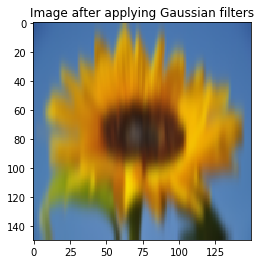

In [12]:
plt.imshow(gaussx_train[1277])
plt.title("Image after applying Gaussian filters")
plt.show()

**Image Normalization**

In [13]:
gaborx_train=np.array(gaborx_train)/255
gaborx_val=np.array(gaborx_val)/255
gaborx_test=np.array(gaborx_test)/255

In [14]:
sharpx_train=np.array(sharpx_train)/255
sharpx_val=np.array(sharpx_val)/255
sharpx_test=np.array(sharpx_test)/255

In [15]:
gaussx_train=np.array(gaussx_train)/255
gaussx_val=np.array(gaussx_val)/255
gaussx_test=np.array(gaussx_test)/255

**Sharp-CNN**

In [16]:
input1 = Input(shape=(size, size, 3))
x1 = Conv2D(filters = 32, kernel_size = 5, padding = 'same', activation = 'relu')(input1)
x1 = MaxPooling2D((2, 2))(x1)
x1 = Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')(x1)
x1 = MaxPooling2D((2, 2),strides=(2,2))(x1)
x1 = Conv2D(filters = 96, kernel_size = 3, padding = 'same', activation = 'relu')(x1)
x1 = MaxPooling2D((2, 2),strides=(2,2))(x1)
x1 = Conv2D(filters = 96, kernel_size = 3, padding = 'same', activation = 'relu')(x1)
x1 = MaxPooling2D((2, 2),strides=(2,2))(x1)
x1 = Flatten()(x1)
x1 = Dense(512)(x1)
x1 = Activation('relu')(x1)
out1 = Dense(5, activation = "softmax")(x1)

sharpmodel = Model(input1, out1)
sharpmodel.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

**callback function**

In [17]:
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, factor = 0.1, min_lr = 0.00001)
checkpoint = ModelCheckpoint('modelsharpbest.h5', monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 1e-10, patience = 10, verbose = 1, restore_best_weights = True)

callbacks = [reduce_learning_rate, checkpoint, early_stopping]

**Sharp-Training**

In [18]:
history1 = sharpmodel.fit(sharpx_train,y_train, batch_size=128,
                              epochs = 30, 
                              validation_data = (sharpx_val,y_val),
                              callbacks=callbacks,
                              verbose = 1,
                              )

Train on 3107 samples, validate on 346 samples
Epoch 1/30
3107/3107 [==============================] - 10s 3ms/step - loss: 0.5001 - acc: 0.7927 - val_loss: 0.4461 - val_acc: 0.8081

Epoch 00001: val_acc improved from -inf to 0.80809, saving model to modelsharpbest.h5
Epoch 2/30
3107/3107 [==============================] - 3s 1ms/step - loss: 0.4290 - acc: 0.8110 - val_loss: 0.4060 - val_acc: 0.8098

Epoch 00002: val_acc improved from 0.80809 to 0.80983, saving model to modelsharpbest.h5
Epoch 3/30
3107/3107 [==============================] - 4s 1ms/step - loss: 0.3948 - acc: 0.8229 - val_loss: 0.3743 - val_acc: 0.8179

Epoch 00003: val_acc improved from 0.80983 to 0.81792, saving model to modelsharpbest.h5
Epoch 4/30
3107/3107 [==============================] - 3s 1ms/step - loss: 0.3574 - acc: 0.8406 - val_loss: 0.3503 - val_acc: 0.8422

Epoch 00004: val_acc improved from 0.81792 to 0.84220, saving model to modelsharpbest.h5
Epoch 5/30
3107/3107 [==============================] - 3s 

**Visualization of the model**

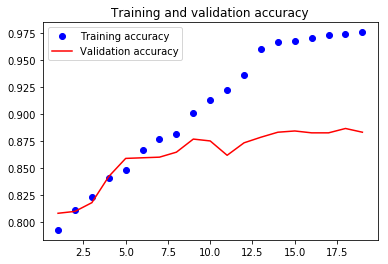

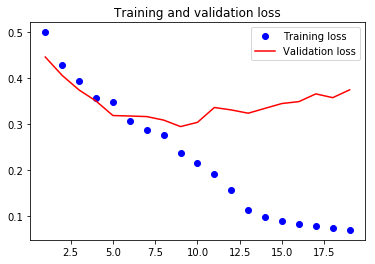

In [19]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [20]:
pred1=np.argmax(sharpmodel.predict(sharpx_test),axis=1)

**Confusion matrix**

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                              cmap=plt.cm.Greens):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

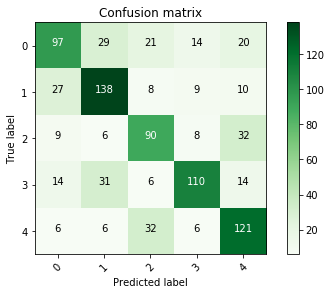

In [22]:
confusion_mtx1 = confusion_matrix(pred1, np.argmax(y_test,axis=1))
plot_confusion_matrix(confusion_mtx1, classes = range(5))

**evaluation**

In [23]:
sharpmodel.evaluate(sharpx_test,y_test)

864/864 [==============================] - 1s 584us/step


[0.3164045959711075, 0.8699074122640822]

In [24]:
sharpmodel.save('sharp_model.h5')

**Guassian-CNN**

In [25]:
input2 = Input(shape=(size, size, 3))
x2 = Conv2D(filters = 32, kernel_size = 5, padding = 'same', activation = 'relu')(input2)
x2 = MaxPooling2D((2, 2))(x2)
x2 = Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')(x2)
x2 = MaxPooling2D((2, 2),strides=(2,2))(x2)
x2 = Conv2D(filters = 96, kernel_size = 3, padding = 'same', activation = 'relu')(x2)
x2 = MaxPooling2D((2, 2),strides=(2,2))(x2)
x2 = Conv2D(filters = 96, kernel_size = 3, padding = 'same', activation = 'relu')(x2)
x2 = MaxPooling2D((2, 2),strides=(2,2))(x2)
x2 = Flatten()(x2)
x2 = Dense(512)(x2)
x2 = Activation('relu')(x2)
out2 = Dense(5, activation = "softmax")(x2)

gaussmodel = Model(input2, out2)
gaussmodel.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

**Callback function**

In [26]:
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, factor = 0.1, min_lr = 0.00001)
checkpoint = ModelCheckpoint('modelgaussbest.h5', monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 1e-10, patience = 10, verbose = 1, restore_best_weights = True)

callbacks = [reduce_learning_rate, checkpoint, early_stopping]

**Guassian Training**

In [27]:
history2 = gaussmodel.fit(gaussx_train,y_train, batch_size=128,
                              epochs = 30, 
                              validation_data = (gaussx_val,y_val),
                              callbacks=callbacks,
                              verbose = 1,
                        )

Train on 3107 samples, validate on 346 samples
Epoch 1/30
3107/3107 [==============================] - 4s 1ms/step - loss: 0.4511 - acc: 0.8026 - val_loss: 0.3898 - val_acc: 0.8231

Epoch 00001: val_acc improved from -inf to 0.82312, saving model to modelgaussbest.h5
Epoch 2/30
3107/3107 [==============================] - 4s 1ms/step - loss: 0.3781 - acc: 0.8278 - val_loss: 0.3777 - val_acc: 0.8243

Epoch 00002: val_acc improved from 0.82312 to 0.82428, saving model to modelgaussbest.h5
Epoch 3/30
3107/3107 [==============================] - 4s 1ms/step - loss: 0.3578 - acc: 0.8389 - val_loss: 0.3391 - val_acc: 0.8410

Epoch 00003: val_acc improved from 0.82428 to 0.84104, saving model to modelgaussbest.h5
Epoch 4/30
3107/3107 [==============================] - 4s 1ms/step - loss: 0.3246 - acc: 0.8594 - val_loss: 0.3545 - val_acc: 0.8428

Epoch 00004: val_acc improved from 0.84104 to 0.84277, saving model to modelgaussbest.h5
Epoch 5/30
3107/3107 [==============================] - 4s 1

**visualization of model**

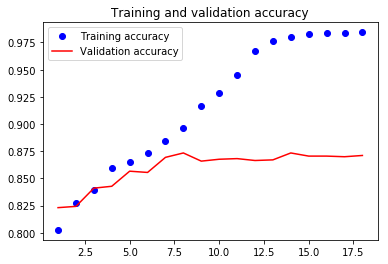

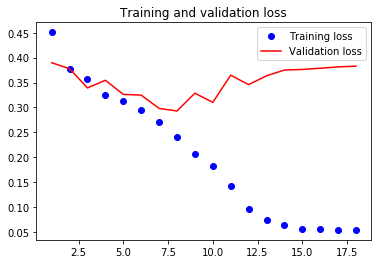

In [28]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [29]:
pred2=np.argmax(gaussmodel.predict(gaussx_test),axis=1)

**confusion matrix**

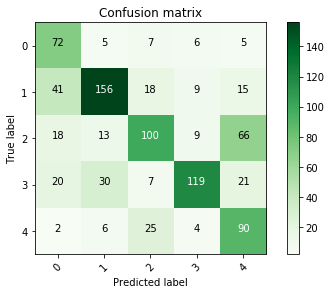

In [30]:
confusion_mtx2 = confusion_matrix(pred2, np.argmax(y_test,axis=1))
plot_confusion_matrix(confusion_mtx2, classes = range(5))

**evaluation**

In [31]:
gaussmodel.evaluate(gaussx_test,y_test)

864/864 [==============================] - 1s 666us/step


[0.3355170653926002, 0.8590277852835478]

In [32]:
gaussmodel.save('gauss_model.h5')

**Gabor-CNN**

In [33]:
input3 = Input(shape=(size, size, 3))
x3 = Conv2D(filters = 32, kernel_size = 5, padding = 'same', activation = 'relu')(input3)
x3 = MaxPooling2D((2, 2))(x3)
x3 = Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')(x3)
x3 = MaxPooling2D((2, 2),strides=(2,2))(x3)
x3 = Conv2D(filters = 96, kernel_size = 3, padding = 'same', activation = 'relu')(x3)
x3 = MaxPooling2D((2, 2),strides=(2,2))(x3)
x3 = Conv2D(filters = 96, kernel_size = 3, padding = 'same', activation = 'relu')(x3)
x3 = MaxPooling2D((2, 2),strides=(2,2))(x3)
x3 = Flatten()(x3)
x3 = Dense(512)(x3)
x3 = Activation('relu')(x3)
out3 = Dense(5, activation = "softmax")(x3)

gabormodel = Model(input3, out3)
gabormodel.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

**callback function**

In [34]:
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, factor = 0.1, min_lr = 0.00001)
checkpoint = ModelCheckpoint('modelgaborbest.h5', monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 1e-10, patience = 10, verbose = 1, restore_best_weights = True)

callbacks = [reduce_learning_rate, checkpoint, early_stopping]

**Gabor Training**

In [35]:
history3 = gabormodel.fit(gaborx_train,y_train, batch_size=128,
                              epochs = 30, 
                              validation_data = (gaborx_val,y_val),
                              callbacks=callbacks,
                              verbose = 1,
                             )

Train on 3107 samples, validate on 346 samples
Epoch 1/30
3107/3107 [==============================] - 4s 1ms/step - loss: 0.4948 - acc: 0.7948 - val_loss: 0.4385 - val_acc: 0.8000

Epoch 00001: val_acc improved from -inf to 0.80000, saving model to modelgaborbest.h5
Epoch 2/30
3107/3107 [==============================] - 3s 1ms/step - loss: 0.4365 - acc: 0.8029 - val_loss: 0.4088 - val_acc: 0.8162

Epoch 00002: val_acc improved from 0.80000 to 0.81619, saving model to modelgaborbest.h5
Epoch 3/30
3107/3107 [==============================] - 4s 1ms/step - loss: 0.3923 - acc: 0.8182 - val_loss: 0.3775 - val_acc: 0.8220

Epoch 00003: val_acc improved from 0.81619 to 0.82197, saving model to modelgaborbest.h5
Epoch 4/30
3107/3107 [==============================] - 4s 1ms/step - loss: 0.3611 - acc: 0.8359 - val_loss: 0.3459 - val_acc: 0.8428

Epoch 00004: val_acc improved from 0.82197 to 0.84277, saving model to modelgaborbest.h5
Epoch 5/30
3107/3107 [==============================] - 3s 1

**visualization of model**

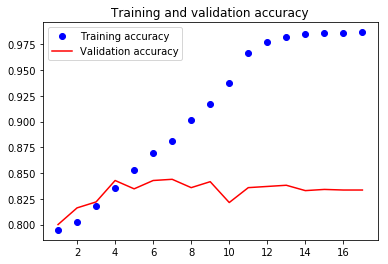

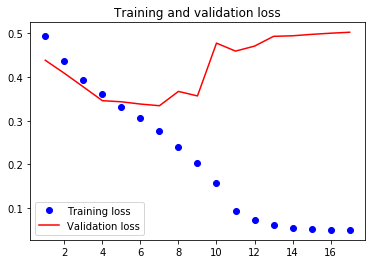

In [36]:
acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [37]:
pred3=np.argmax(gabormodel.predict(gaborx_test),axis=1)

**confusion matrix**

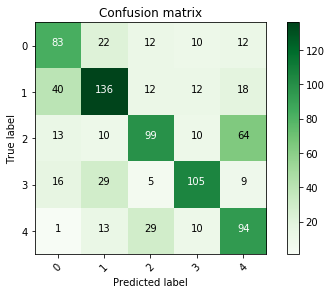

In [38]:
confusion_mtx3 = confusion_matrix(pred3, np.argmax(y_test,axis=1))
plot_confusion_matrix(confusion_mtx3, classes = range(5))

**evaluation**

In [39]:
gabormodel.evaluate(gaborx_test,y_test)

864/864 [==============================] - 1s 606us/step


[0.34159449957035204, 0.8537037019376401]

In [40]:
gabormodel.save('gabor_model.h5')

**Creating a Merged CNN**

In [41]:
inputa = Input(shape=(size, size, 3))
x = Conv2D(filters = 32, kernel_size = 5, padding = 'same', activation = 'relu')(inputa)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')(x)
x = MaxPooling2D((2, 2),strides=(2,2))(x)
x = Conv2D(filters = 96, kernel_size = 3, padding = 'same', activation = 'relu')(x)
x = MaxPooling2D((2, 2),strides=(2,2))(x)
x = Conv2D(filters = 96, kernel_size = 3, padding = 'same', activation = 'selu')(x)
x = MaxPooling2D((2, 2),strides=(2,2))(x)
x = AlphaDropout(0.3,seed = 2019)(x)
outa = Flatten()(x)


inputb = Input(shape=(size, size, 3))
x = Conv2D(filters = 32, kernel_size = 5, padding = 'same', activation = 'relu')(inputb)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')(x)
x = MaxPooling2D((2, 2),strides=(2,2))(x)
x = Conv2D(filters = 96, kernel_size = 3, padding = 'same', activation = 'relu')(x)
x = MaxPooling2D((2, 2),strides=(2,2))(x)
x = Conv2D(filters = 96, kernel_size = 3, padding = 'same', activation = 'selu')(x)
x = MaxPooling2D((2, 2),strides=(2,2))(x)
x = AlphaDropout(0.3,seed = 2019)(x)
outb = Flatten()(x)

inputc = Input(shape=(size, size, 3))
x = Conv2D(filters = 32, kernel_size = 5, padding = 'same', activation = 'relu')(inputc)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')(x)
x = MaxPooling2D((2, 2),strides=(2,2))(x)
x = Conv2D(filters = 96, kernel_size = 3, padding = 'same', activation = 'relu')(x)
x = MaxPooling2D((2, 2),strides=(2,2))(x)
x = Conv2D(filters = 96, kernel_size = 3, padding = 'same', activation = 'selu')(x)
x = MaxPooling2D((2, 2),strides=(2,2))(x)
x = AlphaDropout(0.3,seed = 2019)(x)
outc = Flatten()(x)


concatenated = concatenate([outa, outb, outc])

x = Dense(1024)(concatenated)
x = Activation('sigmoid')(x)
x = Dense(512)(concatenated)
x = Activation('sigmoid')(x)
outd = Dense(5, activation = "softmax")(x)




mergemodel = Model([inputa, inputb, inputc], outd)
mergemodel.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

**Creating Callback Functions**

In [42]:
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, factor = 0.1, min_lr = 0.00001)
checkpoint = ModelCheckpoint('modelmergebest.h5', monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 1e-10, patience = 4, verbose = 1, restore_best_weights = True)

callbacks = [reduce_learning_rate, checkpoint, early_stopping]

**Training the model using Gaussian Features**

In [43]:
history4 = mergemodel.fit([gaussx_train,gaborx_train,sharpx_train],y_train, batch_size=128,
                              epochs = 30, 
                              validation_data = ([gaussx_val,gaborx_val,sharpx_val],y_val),
                              callbacks=callbacks,
                              verbose = 1,
                              )

Train on 3107 samples, validate on 346 samples
Epoch 1/30
3107/3107 [==============================] - 14s 4ms/step - loss: 0.6756 - acc: 0.7447 - val_loss: 0.5376 - val_acc: 0.7699

Epoch 00001: val_acc improved from -inf to 0.76994, saving model to modelmergebest.h5
Epoch 2/30
3107/3107 [==============================] - 11s 4ms/step - loss: 0.4830 - acc: 0.7916 - val_loss: 0.4031 - val_acc: 0.8156

Epoch 00002: val_acc improved from 0.76994 to 0.81561, saving model to modelmergebest.h5
Epoch 3/30
3107/3107 [==============================] - 11s 4ms/step - loss: 0.3818 - acc: 0.8220 - val_loss: 0.3630 - val_acc: 0.8306

Epoch 00003: val_acc improved from 0.81561 to 0.83064, saving model to modelmergebest.h5
Epoch 4/30
3107/3107 [==============================] - 11s 4ms/step - loss: 0.3736 - acc: 0.8304 - val_loss: 0.3594 - val_acc: 0.8341

Epoch 00004: val_acc improved from 0.83064 to 0.83410, saving model to modelmergebest.h5
Epoch 5/30
3107/3107 [==============================] - 

**Visualisation of the Model Training**

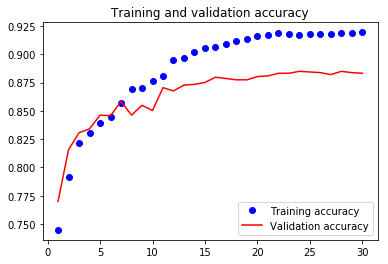

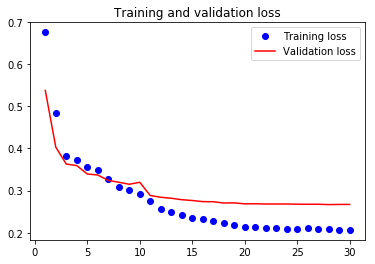

In [44]:
acc = history4.history['acc']
val_acc = history4.history['val_acc']
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [45]:
pred4=np.argmax(mergemodel.predict([gaussx_test,gaborx_test,sharpx_test]),axis=1)

**Plotting Confusion Matrix**

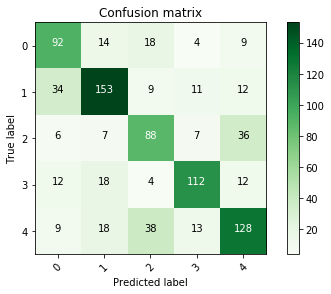

In [46]:
confusion_mtx4 = confusion_matrix(pred4, np.argmax(y_test,axis=1))
plot_confusion_matrix(confusion_mtx4, classes = range(5))

**Evaluating the model using Testing Data**

In [47]:
mergemodel.evaluate([gaussx_test,gaborx_test,sharpx_test],y_test)

864/864 [==============================] - 2s 2ms/step


[0.2962832897901535, 0.8782407354425501]

In [48]:
mergemodel.save('merged_model.h5')